In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import timedelta
import os
plt.style.use("seaborn")

In [2]:
!pip install wget
import wget
url ="https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv"
output_directory = "/content"
# os.remove("/content/cases-brazil-states.csv")
filename = wget.download(url, out=output_directory)
filename

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=7ee684173d267707239e9a6f9666b2e2689637de498d67a01a880e7f2971fe97
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


'/content/cases-brazil-states.csv'

In [0]:
# tabela :: wget -r https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv
dates = pd.read_csv(filename,header=0,index_col="date")

In [0]:
# estado = dates[dates["state"] == "TOTAL"]
# print(estado.totalCases)
cfm = dates['deaths']/dates["totalCases"]

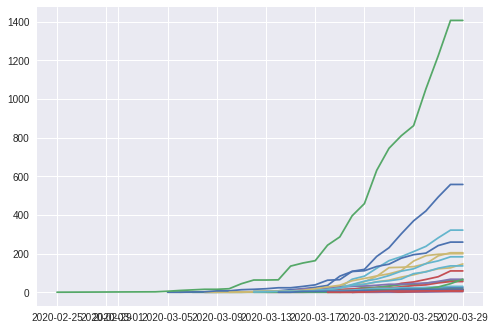

In [7]:
listaEstados =  sorted(dates["state"].unique())[:-1]
dates.index = pd.to_datetime(dates.index)
for ke in listaEstados:
  estado = dates[dates["state"] == ke]
  plt.plot(estado["totalCases"])
plt.grid(1)
plt.show()

In [103]:
estado = dates[dates["state"] == "TOTAL"]
  # estado.index = pd.to_datetime(estado.index)
cem = estado["deaths"]/estado["totalCases"]
estado

,country,state,city,deaths,newCases,totalCases
date,,,,,,
2020-02-25,Brazil,TOTAL,TOTAL,0,1,1
2020-02-29,Brazil,TOTAL,TOTAL,0,1,2
2020-03-04,Brazil,TOTAL,TOTAL,0,1,3
2020-03-05,Brazil,TOTAL,TOTAL,0,5,8
2020-03-06,Brazil,TOTAL,TOTAL,0,5,13
2020-03-07,Brazil,TOTAL,TOTAL,0,6,19
2020-03-08,Brazil,TOTAL,TOTAL,0,6,25
2020-03-09,Brazil,TOTAL,TOTAL,0,5,30
2020-03-10,Brazil,TOTAL,TOTAL,0,5,35


In [0]:
# ajuste exponencial com a func, dos dasos xdata e ydata Brasil
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(b * x) + c
def funcpol(x, a, b):
    return a * x + b


# modifica os dados para utilizar no curve fit

today=datetime.now().date()
# lista os estados 
listaEstados = sorted(dates["state"].unique())[:-1]
coef_estado = pd.DataFrame(columns=["Estado","coefts","coefts_err","Ajuste","cfm","ndata","pcaso"])
for ke in listaEstados:
  xtimebr=[]; ydatabr=[]; dia=[]
  estado = dates[dates["state"] == ke]
  estado.index = pd.to_datetime(estado.index)
  cem = estado["deaths"]/estado["totalCases"]
  if cem[-1] == 0.0: 
    cfm = cem[-2]
  else: cfm = cem[-1]

# primeiro caso no estado dia
  case1 = estado.index[np.where(estado["totalCases"] > 0)][0]
  for ib in enumerate(estado.index):
    # somente dias onde o numero de casos confirmados é maior que 0
    if estado["totalCases"][estado.index[ib[0]]] >0:
      # procura os dias..
      selday = ((ib[1])-case1).days == np.arange(0,len(estado)+3,3)
      # a cada dois dias pegamos o numero de casos e convete o dia para dia inteiro
      # dia negativo está no passado.. -2 ==dois dias antes do atual var(today)
      if True in selday:
        xtimebr.append((ib[1]-case1).days)
        ydatabr.append(estado["totalCases"][estado.index[ib[0]]])
        dia.append(estado.index[ib[0]])

  # dados selecionador para fazer o ajsute
  ydatabr  = np.array(ydatabr)
  xdatabr = np.array(xtimebr)
  ilista = ["AC","MA","MT","PI","RO","RR","SE","TO"]#,"PE","RO","PA","PB","AP"
  if ke in ilista:
    poptbr, pcovbr = curve_fit(funcpol, xdatabr, ydatabr)
    Ajuste = "Linear"
    lendata = len(ydatabr)
  else:
    # print(ke)
    poptbr, pcovbr = curve_fit(func, xdatabr, ydatabr)
    Ajuste = "Expo"
    lendata = len(ydatabr)
  perrbr = np.sqrt(np.diag(pcovbr))
  coef_estado.loc[len(coef_estado),:] = [ke,poptbr,perrbr,Ajuste,cfm,lendata,case1]
# coef_estado

# #  cria 5 dias para previsão
# for i in range(5):
#   dia.append(dia[-1]+timedelta(days=1))

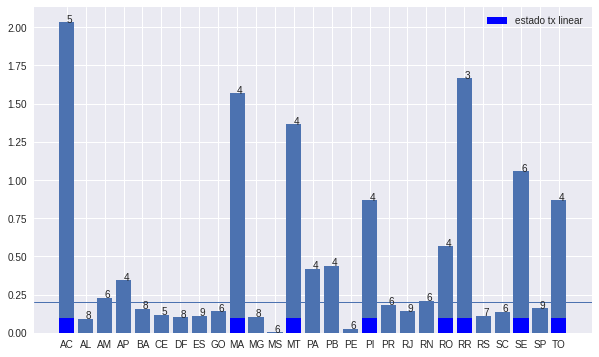

In [110]:

fig, ax = plt.subplots(figsize=(10,6))
coefl=[]
for ik in coef_estado.loc[:,"coefts"]:
  if len(ik) != 3:
    coefl.append(ik[0])
  else:
    coefl.append(ik[1])
ndata = (coef_estado["ndata"].values).astype(np.str)
coefl=np.array(coefl)
plt.bar(coef_estado.loc[:,"Estado"],coefl)
for ii in range(len(ndata)):
  plt.text(coef_estado.loc[:,"Estado"][ii],coefl[ii],ndata[ii])
plt.bar(ilista,np.ones(len(ilista))*0.1,color="b",label="estado tx linear")
plt.axhline(0.2,lw=1.0)
plt.legend()
# plt.ylim(0,2)
plt.show()

In [0]:
# # ajuste exponencial com a func, dos dasos xdata e ydata Brasil
# from scipy.optimize import curve_fit
# def func(x, a, b, c):
#     return a * np.exp(b * x) + c

# # Brasil
# poptbr, pcovbr = curve_fit(func, xdatabr, ydatabr)
# perrbr = np.sqrt(np.diag(pcovbr))
# poptbr

### model SIR
https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

Model SIER
https://github.com/XuelongSun/Dynamic-Model-of-Infectious-Diseases/blob/master/SIR.ipynb

In [0]:
def Model_SEIR(coef_lamb,dias_espostos,iv_isol):
  #  MODELO S E I R 
# population
  N = 1e3
# simuation Time / Day
  T = 160
  tm = np.linspace(0, T, T)
# susceptiable ratio
  s = np.zeros([T])
# exposed ratio
  e = np.zeros([T])
# infective ratio
  i = np.zeros([T])
# remove ratio
  r = np.zeros([T])
# contact rate
  # lamda = 0.2
  lamba = coef_lamb
  # recover rate
  gamma = 0.0821
  # gamma = coef_gamma
  # exposed period
  sigma = 1 / float(dias_espostos)

  # initial infective people
  i[0] = 1.0 / N
  e[0] = iv_isol / N
  s[0] = N / N - i[0] - e[0]
  # s[0] = N / N
  for t in range(T-1):
      s[t + 1] = s[t] - lamda * s[t] * i[t]
      e[t + 1] = e[t] + lamda * s[t] * i[t] - sigma * e[t]
      i[t + 1] = i[t] + sigma * e[t] - gamma * i[t]
      r[t + 1] = r[t] + gamma * i[t]
  return s,e,i,r

In [0]:
def Model_SIR(coef_lamb,cfm_tx):

 # population
  N = 1e4
  # simuation Time / Day
  T = 170
  # susceptiable ratio
  s = np.zeros([T])
  # infective ratio
  i = np.zeros([T])
  # remove ratio
  r = np.zeros([T])

  # contact rate
  lamda = coef_lamb
  # recover rate
  gamma = cfm_tx

  # initial infective people
  i[0] = 1.0 / N
  r[0] = 0.0 / N
  s[0] = N / N - i[0] - r[0]
  for t in range(T-1):
      i[t + 1] = i[t] + i[t] * lamda * s[t] - gamma*i[t]
      s[t + 1] = s[t] - lamda * s[t] * i[t]
      r[t + 1] = r[t] + gamma*i[t]
  return s,i,r

In [0]:
# seleciona o estado
list_estado = ["RS","RJ","SP","SC"] 
for UF in list_estado:
  # UF="SP"
  ik = coef_estado.loc[:,["Estado","coefts","pcaso","cfm"]]
  ikd = ik.loc[:,"Estado"] == UF
  ikd = ikd.index[ikd == True].values
  nk = ik.loc[ikd,"coefts"].values[0]
  if len(nk) != 3:
    coefl = nk[0]
  else:
    coefl = nk[1]
  caso1 = coef_estado["pcaso"][ikd].values
  cfm = ik.loc[ikd,"cfm"].values
  s,i,r = Model_SIR(coefl,cfm)
  if UF == "RS": RS_i = i ; RS_dia = []
  if UF == "SC": SC_i = i ; SC_dia = []
  if UF == "SP": SP_i = i ; SP_dia = []
  if UF == "RJ": RJ_i = i ; RJ_dia = []
  for kk in range(len(i)):
    if UF == "SP": SP_dia.append(caso1[0]+timedelta(days=kk))
    if UF == "SC": SC_dia.append(caso1[0]+timedelta(days=kk))
    if UF == "RS": RS_dia.append(caso1[0]+timedelta(days=kk))
    if UF == "RJ": RJ_dia.append(caso1[0]+timedelta(days=kk))

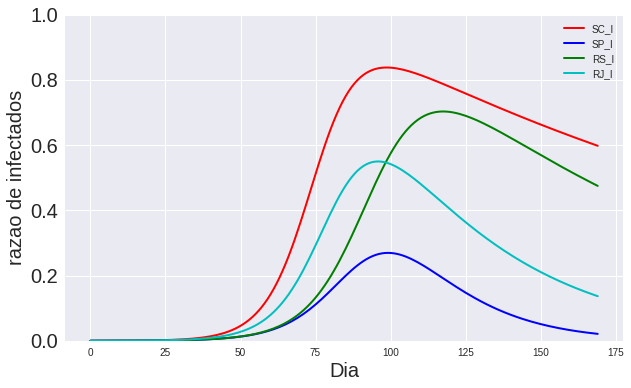

In [52]:
fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(s, c='b', lw=2, label='S')
# ax.plot(diasim,e, c='orange', lw=2, label='E')
ax.plot(SC_i, c='r', lw=2, label='SC_I')
ax.plot(SP_i, c='b', lw=2, label='SP_I')
ax.plot(RS_i, c='g', lw=2, label='RS_I')
ax.plot(RJ_i, c='c', lw=2, label='RJ_I')
# ax.plot(r, c='g', lw=2, label='R')
ax.set_xlabel('Dia',fontsize=20)
ax.set_ylabel('razao de infectados', fontsize=20)
ax.grid(1)
ax.set_ylim(0,1.)
# ax.set_xlim(today,diasim[-1])
plt.xticks(fontsize=10)
plt.yticks(fontsize=20)
plt.legend();

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([ 65.28070175,   0.13196215, -54.28070175])

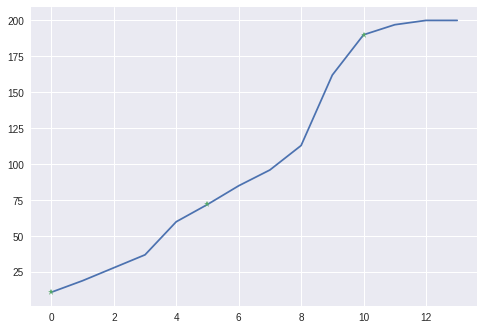

In [102]:
estado = dates[dates["state"] == "RS"]
inter = estado[estado["totalCases"] > 10 ]
cem = inter["deaths"]/inter["totalCases"]
plt.plot(inter["totalCases"].values)
ynw = inter.totalCases.values[::5]
xnw = np.arange(0,len(ynw)*5,5)
um , doi = curve_fit(func,xnw,ynw)
plt.plot(xnw,func(xnw,*um),"*")
# plt.plot(xnw,ynw)
um

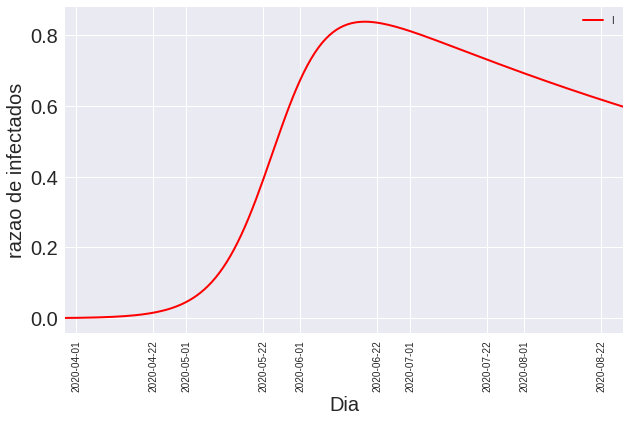

In [55]:
diasim = []
for kk in range(170):
  diasim.append(caso1[0]+timedelta(days=kk))
  
fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(s, c='b', lw=2, label='S')
# ax.plot(diasim,e, c='orange', lw=2, label='E')
ax.plot(diasim,i, c='r', lw=2, label='I')
# ax.plot(r, c='g', lw=2, label='R')
ax.set_xlabel('Dia',fontsize=20)
ax.set_ylabel('razao de infectados', fontsize=20)
ax.grid(1)
# ax.set_xlim(0,50)
ax.set_xlim(today,diasim[-1])
plt.xticks(fontsize=10,rotation=90)
plt.yticks(fontsize=20)

plt.legend();